# Project 1: Denver commuter and apartment rental price

####                                                                                             <div style="text-align: right"> JOSH JEFFERSON,  DAVID LEE,  BRETT KOLINEK,  MOHAMED AWOUDA </div>

## 0. Dependencies

In [3]:
# OS
import os

# For regular expression
import re

# API and Web scraping
import requests
import json
from bs4 import BeautifulSoup
from pprint import pprint
from census import Census

# Data processing
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None

import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

import folium
from folium import plugins, FeatureGroup, LayerControl, TileLayer
from branca.colormap import linear

# API KEYs
gkey = os.environ['GOOGLE_API_KEY2']  # Replace "os.environ['GOOGLE_API_KEY2']" with your Google API key
census_key=os.environ['CENSUS_API_KEY'] # Replace "os.environ['GOOGLE_API_KEY2']" with your Census API key

## 1. Rawdata extraction from Apartments.com by web scraping

<div class="alert alert-block alert-info">
    <font size="4">1. With given URLs, the scraper extracts relevant information from pages. <br>
    2. Calculate the <strong><tt>distance</tt></strong> and <strong><tt>travel time</tt></strong> between apartment and destination through <strong><tt><i>GOOGLE Distance Matrix API</i></tt></strong>. <br>
    3. The scraper write the results to a csv file per an area.</font>
</div>

In [4]:
!python ../apartments-scraper/parse_apartments.py

Now getting apartments from: https://www.apartments.com/?sk=6feeb2a8e3113934718fda5bc3af92b9&bb=_mlnn9kpgMl6vomlZ


## 2. Data cleaning for the rawdata from apartment.com

<div class="alert alert-block alert-info">
    <font size="4">1. Extract <b><tt>minimum rental price</tt></b> from a range of rental price for each apartment. <br>
        2. Remove unit for both <b><tt>distance</tt></b> and <b><tt>travel time</tt></b>. <br></font>
</div>

In [5]:
df_dtc = pd.read_csv('../Resources/commute_to_DTC.csv') # Load apartments data around DTC
df_lodo = pd.read_csv('../Resources/commute_to_Lodo.csv') # Load apartments data around Lodo
df_boulder = pd.read_csv('../Resources/commute_to_Boulder.csv') # Load apartments data around Boulder

In [6]:
# Data cleaning - Choose minimum rental price and size for each bedroom type, and remove units in distance and duration.
def cleaning_dataframe(df):
    try:
        df['Rent_1Bedroom'] = df['Rent_1Bedroom'].astype(str).map(lambda x: x.split("-")[0]).astype(float)
        df['Rent_2Bedrooms'] = df['Rent_2Bedrooms'].astype(str).map(lambda x: x.split("-")[0]).astype(float)
        df['Distance'] = df['Distance'].map(lambda x: str(x).replace("mi", "").strip()).astype(float)
        df['Duration'] = df['Duration'].map(lambda x: str(x).replace("mins", "") if "mins" in x else str(float(x.replace("hour",""))*60)).astype(float)
        df['Size_1Bedroom'] = df['Size_1Bedroom'].map(lambda x: str(x).split()[0].replace(",", "")).astype(float)
        df['Size_2Bedrooms'] = df['Size_2Bedrooms'].map(lambda x: str(x).split()[0].replace(",", "")).astype(float)
        return df
    except:
        print("Check your column names.")


In [7]:
df_DTC = cleaning_dataframe(df_dtc)
df_Lodo = cleaning_dataframe(df_lodo)
df_Boulder = cleaning_dataframe(df_boulder)

<div class="alert alert-block alert-info">
    <font size="4">3. Extract apartment addresses and zipcodes from the rawdata and place them into new columns.<br>
    4. With the addresses, get geo-coordinates for each apartments through <strong><tt><i>GOOGLE Geocode API</i></tt></strong>.<br></font>
</div>

In [8]:
# Extract address and zipcode for each apartment, and get geo-coordinates through Google API.
def get_geocode_and_zipcode(df):
    df['apt_address'] = df['Address'].map(lambda x: re.findall("\[(.*?)\]", str(x))).astype(str)#.replace("[", ""))
    df['apt_address'] = df['apt_address'].map(lambda x: str(x).replace("[","").replace("]","")).astype(str)
    df['apt_geocoords'] = df['apt_address'].map(extract_geocoordinates)

    df['apt_zipcode'] = df['Address'].map(lambda x: re.findall("[\d]{5}\]", str(x))).astype(str)
    df['apt_zipcode'] = df['apt_zipcode'].map(lambda x: str(x).replace("[","").replace("]","").replace("]","")).astype(str)

    return df

# get geocoords through Google API
def extract_geocoordinates(address):
    address = '+'.join(address.split())
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'address' : address,
              'key' : gkey
             }
    resp = requests.get(base_url, params=params).json()
    location = resp.get('results')[0].get('geometry').get('location')

    return location.get('lat'), location.get('lng')


In [9]:
df_DTC = get_geocode_and_zipcode(df_DTC)
df_Lodo = get_geocode_and_zipcode(df_Lodo)
df_Boulder = get_geocode_and_zipcode(df_Boulder)

In [10]:
reordered_columns = ['Option Name', 'Contact', 'Address', 'Size_1Bedroom', 'Size_2Bedrooms',
                     'Rent_1Bedroom', 'Rent_2Bedrooms', 'Distance', 'Duration', 'Pet Policy',
                     'Parking', 'Gym', 'Kitchen', 'Amenities', 'Features', 'Living Space',
                     'Lease Info', 'Services', 'Property Info', 'Indoor Info',
                     'Outdoor Info', 'apt_address', 'apt_geocoords', 'apt_zipcode']
df_DTC = df_DTC[reordered_columns]
df_Lodo = df_Lodo[reordered_columns]
df_Boulder = df_Boulder[reordered_columns]

In [11]:
df_DTC['Area'] = "DTC"
df_Lodo['Area'] = "LODO"
df_Boulder['Area'] = 'Boulder'
df_all = pd.concat([df_DTC, df_Lodo, df_Boulder], ignore_index=True)
df_all.head(1)

,Option Name,Contact,Address,Size_1Bedroom,Size_2Bedrooms,Rent_1Bedroom,Rent_2Bedrooms,Distance,Duration,Pet Policy,Parking,Gym,Kitchen,Amenities,Features,Living Space,Lease Info,Services,Property Info,Indoor Info,Outdoor Info,apt_address,apt_geocoords,apt_zipcode,Area
0,[Palomino Park Resort](https://www.apartments....,720-833-7061,"[6700 Palomino Pky, Highlands Ranch, CO 80130]...",727.0,1125.0,1302.0,1571.0,8.15,13.0,Dogs Allowed Breed and Weight Restrictions App...,Surface Lot 1 space. Parking Available,* Fitness Center * Sauna * Spa * Pool * Playgr...,* Dishwasher * Disposal * Ice Maker * Granite ...,"* 1,2 & 3 Bedroom Apartments & Townhomes * 26 ...",* High Speed Internet Access * Wi-Fi * Washer/...,* Hardwood Floors * Carpet * Vinyl Flooring * ...,"3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13",* Package Service * Community-Wide WiFi * Wi-F...,* Built in 1996 * 1184 Units/2 Stories * Furni...,* Business Center * Clubhouse * Lounge * Stora...,* Gated * Sundeck * Cabana * Grill * Picnic Ar...,"'6700 Palomino Pky, Highlands Ranch, CO 80130'","(39.5578103, -104.9103433)",'80130',DTC


<div class="alert alert-block alert-info">
    <font size="4"><p>5. Split property information from the column <b><tt>Property Info</tt></b> to separate into new columns. </p></font>
    <font size="3"><p style="text-indent: 40px">- Four information possible for now: <b><tt><i>Year built</i></tt></b>, &nbsp;  <b><tt><i>Furnished</i></tt></b>, &nbsp;
        <b><tt><i>Total Units of apartment</i></tt></b>, &nbsp; <b><tt><i>Renovated</i></tt></b></p></font>
</div>

In [12]:
df_all['Property Info'].fillna(value="", inplace=True)

In [13]:
# Get 4 major property information - year built, renovated, furnished and total units for each apartment

df_all['Year_built'] = df_all['Property Info'].str.extract(r'(\d{4})', expand=False).fillna(0).astype(int)

mask_renovated = df_all['Property Info'].str.contains('Renovated')
df_all['Renovated'] = np.where(mask_renovated, 1, 0)

mask_furnished = df_all['Property Info'].str.contains('Furnished')
df_all['Furnished'] = np.where(mask_furnished, 1, 0)

df_all['Total_Units'] = df_all['Property Info'].str.extract(r'(\d{1,}) Unit', expand=False).fillna(0).astype(int)


## 3. Combining US census data into the dataframe

<div class="alert alert-block alert-info">
    <font size="4">1. Using <strong><tt>Census</tt></strong> library, get <strong><tt><i>US Census ACS5</i></tt></strong> data for 2017.</font>
</div>

In [14]:
# Run Census Search to retrieve data on all zip codes (2017 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

c = Census(census_key, year=2017)

census_data = c.acs5.get(
                         ("B01003_001E", "B23025_005E", "B02001_002E", "B02001_003E",
                          "B02001_004E", "B02001_005E", "B02001_006E", "B02001_008E",
                          "B03001_003E", "B25058_001E", "B25058_001EA", "B25058_001M",
                          "B25058_001MA"
                         ),
                         {'for': 'zip code tabulation area: *'}
                        )

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df = census_df.rename(columns={"B01003_001E": "Population",
                                      "B23025_005E": "Unemployment Count",
                                      "B02001_002E": "population_white_alone",
                                      "B02001_003E": "population_black_alone",
                                      "B02001_004E": "population_american_indian_alone",
                                      "B02001_005E": "population_asian_alone",
                                      "B02001_006E": "population_native_hawaiian_alone",
                                      "B02001_008E": "population_two_or_more_races",
                                      "B03001_003E": "population_hispanic_origin",
                                      "B25058_001E": "median_contract_rent",
                                      "B25058_001EA": "median_contract_rent_anno",   
                                      "B25058_001M": "median_contract_rent_ME",      # Error of Margin
                                      "B25058_001MA": "median_contract_rent_ME_anno",
                                      "zip code tabulation area": "Zipcode"})



# Add in Employment Rate (Employment Count / Population)
census_df["Unemployment Rate"] = 100 * \
    census_df["Unemployment Count"].astype(int) / census_df["Population"].astype(int)

# # Final DataFrame
census_df = census_df[["Zipcode", "Population", "Unemployment Rate", "population_white_alone",
                      "population_black_alone", "population_american_indian_alone", "population_asian_alone",
                       "population_native_hawaiian_alone", "population_two_or_more_races", "population_hispanic_origin",
                       "median_contract_rent", "median_contract_rent_anno", "median_contract_rent_ME", "median_contract_rent_ME_anno"
                     ]]

# Visualize
census_df.head()

,Zipcode,Population,Unemployment Rate,population_white_alone,population_black_alone,population_american_indian_alone,population_asian_alone,population_native_hawaiian_alone,population_two_or_more_races,population_hispanic_origin,median_contract_rent,median_contract_rent_anno,median_contract_rent_ME,median_contract_rent_ME_anno
0,00601,17599.0,13.943974,13686.0,120.0,17.0,0.0,0.0,135.0,17533.0,291.0,None,18.0,None
1,00602,39209.0,6.473004,26213.0,1092.0,0.0,0.0,0.0,10314.0,36736.0,304.0,None,23.0,None
2,00603,50135.0,7.156677,35709.0,1985.0,131.0,557.0,10.0,4321.0,48865.0,306.0,None,28.0,None
3,00606,6304.0,3.236041,3045.0,160.0,22.0,0.0,0.0,173.0,6292.0,185.0,None,40.0,None
4,00610,27590.0,5.342515,17038.0,845.0,0.0,0.0,1.0,2722.0,26850.0,322.0,None,29.0,None


<div class="alert alert-block alert-info">
    <font size="4">2. Remove non-Colorado zipcodes form the Census dataframe.</font>
</div>

In [15]:
# Create a zip range = 80001 to 81658
zip_range = list(range(80001, 81659))

# Use a mapping with lambda function to check whether each zip code is in Colorado
census_df['Zipcode_check'] = census_df['Zipcode'].map(lambda x: True if int(x) in zip_range else False)

#create new DataFrame
colo_census_pd = census_df.query('Zipcode_check == True')
colo_census_pd.head()

,Zipcode,Population,Unemployment Rate,population_white_alone,population_black_alone,population_american_indian_alone,population_asian_alone,population_native_hawaiian_alone,population_two_or_more_races,population_hispanic_origin,median_contract_rent,median_contract_rent_anno,median_contract_rent_ME,median_contract_rent_ME_anno,Zipcode_check
27793,80002,18211.0,2.169019,16473.0,96.0,358.0,211.0,7.0,391.0,4900.0,922.0,None,59.0,None,True
27794,80003,36657.0,3.148103,32176.0,615.0,477.0,1295.0,0.0,1171.0,8637.0,1101.0,None,47.0,None,True
27795,80004,37241.0,2.728176,34570.0,499.0,329.0,300.0,21.0,1105.0,4912.0,1012.0,None,52.0,None,True
27796,80005,29037.0,1.963013,27334.0,208.0,66.0,759.0,0.0,506.0,2277.0,1215.0,None,85.0,None,True
27797,80007,10174.0,1.346570,9463.0,29.0,95.0,243.0,0.0,164.0,980.0,2316.0,None,321.0,None,True


<div class="alert alert-block alert-info">
    <font size="4">3. Calculate percentage by zipcode for each <b><tt>Census</tt></b> item.</font>
</div>

In [16]:
colo_census_temp = colo_census_pd[['Population', 'population_white_alone',
                                   'population_black_alone', 'population_american_indian_alone',
                                   'population_asian_alone', 'population_native_hawaiian_alone',
                                   'population_two_or_more_races', 'population_hispanic_origin']]

for column in colo_census_temp:
    if not column == 'Population':
        colo_census_pd[column + "_% of popul."] = (colo_census_temp[column] / colo_census_temp["Population"]) * 100

colo_census_pd.head()

,Zipcode,Population,Unemployment Rate,population_white_alone,population_black_alone,population_american_indian_alone,population_asian_alone,population_native_hawaiian_alone,population_two_or_more_races,population_hispanic_origin,median_contract_rent,median_contract_rent_anno,median_contract_rent_ME,median_contract_rent_ME_anno,Zipcode_check,population_white_alone_% of popul.,population_black_alone_% of popul.,population_american_indian_alone_% of popul.,population_asian_alone_% of popul.,population_native_hawaiian_alone_% of popul.,population_two_or_more_races_% of popul.,population_hispanic_origin_% of popul.
27793,80002,18211.0,2.169019,16473.0,96.0,358.0,211.0,7.0,391.0,4900.0,922.0,None,59.0,None,True,90.456318,0.527154,1.965845,1.158640,0.038438,2.147054,26.906815
27794,80003,36657.0,3.148103,32176.0,615.0,477.0,1295.0,0.0,1171.0,8637.0,1101.0,None,47.0,None,True,87.775868,1.677715,1.301252,3.532750,0.000000,3.194479,23.561666
27795,80004,37241.0,2.728176,34570.0,499.0,329.0,300.0,21.0,1105.0,4912.0,1012.0,None,52.0,None,True,92.827797,1.339921,0.883435,0.805564,0.056389,2.967160,13.189764
27796,80005,29037.0,1.963013,27334.0,208.0,66.0,759.0,0.0,506.0,2277.0,1215.0,None,85.0,None,True,94.135069,0.716327,0.227296,2.613906,0.000000,1.742604,7.841719
27797,80007,10174.0,1.346570,9463.0,29.0,95.0,243.0,0.0,164.0,980.0,2316.0,None,321.0,None,True,93.011598,0.285040,0.933753,2.388441,0.000000,1.611952,9.632396


<div class="alert alert-block alert-info">
    <font size="4">4. Join two dataframe: <b><tt>apartment</tt></b> and <b><tt>Census</tt></b>.</font>
</div>

In [17]:
df_all['apt_zipcode'] = df_all['apt_zipcode'].apply(eval)

In [18]:
#combine the apartments data and zip data into new panda dataframe
df_merge = pd.merge(df_all, colo_census_pd,
                    left_on= 'apt_zipcode',
                    right_on= 'Zipcode',
                    how= 'inner'
           )

df_merge.head(1)

,Option Name,Contact,Address,Size_1Bedroom,Size_2Bedrooms,Rent_1Bedroom,Rent_2Bedrooms,Distance,Duration,Pet Policy,Parking,Gym,Kitchen,Amenities,Features,Living Space,Lease Info,Services,Property Info,Indoor Info,Outdoor Info,apt_address,apt_geocoords,apt_zipcode,Area,Year_built,Renovated,Furnished,Total_Units,Zipcode,Population,Unemployment Rate,population_white_alone,population_black_alone,population_american_indian_alone,population_asian_alone,population_native_hawaiian_alone,population_two_or_more_races,population_hispanic_origin,median_contract_rent,median_contract_rent_anno,median_contract_rent_ME,median_contract_rent_ME_anno,Zipcode_check,population_white_alone_% of popul.,population_black_alone_% of popul.,population_american_indian_alone_% of popul.,population_asian_alone_% of popul.,population_native_hawaiian_alone_% of popul.,population_two_or_more_races_% of popul.,population_hispanic_origin_% of popul.
0,[Palomino Park Resort](https://www.apartments....,720-833-7061,"[6700 Palomino Pky, Highlands Ranch, CO 80130]...",727.0,1125.0,1302.0,1571.0,8.15,13.0,Dogs Allowed Breed and Weight Restrictions App...,Surface Lot 1 space. Parking Available,* Fitness Center * Sauna * Spa * Pool * Playgr...,* Dishwasher * Disposal * Ice Maker * Granite ...,"* 1,2 & 3 Bedroom Apartments & Townhomes * 26 ...",* High Speed Internet Access * Wi-Fi * Washer/...,* Hardwood Floors * Carpet * Vinyl Flooring * ...,"3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13",* Package Service * Community-Wide WiFi * Wi-F...,* Built in 1996 * 1184 Units/2 Stories * Furni...,* Business Center * Clubhouse * Lounge * Stora...,* Gated * Sundeck * Cabana * Grill * Picnic Ar...,"'6700 Palomino Pky, Highlands Ranch, CO 80130'","(39.5578103, -104.9103433)",80130,DTC,1996,0,1,1184,80130,28800.0,1.972222,24407.0,336.0,61.0,2391.0,28.0,982.0,2411.0,1667.0,None,87.0,None,True,84.746528,1.166667,0.211806,8.302083,0.097222,3.409722,8.371528


## 4. Data visualization

### Q1.  What is the rental cost of apartments based on rush hour commute times from each location?

<div class="alert alert-block alert-info">
    <font size="4">Calculate basic stats about <b><tt>Rental Price</tt></b> for each area by <b><tt>Commute Time</tt> </b> bins.</font> <br>
    <font size="3"><p style="text-indent: 20px">- Use <b><tt><i>pd.cut</i></tt></b> to divide <b><tt>Duration</tt></b> into 4 bins.</p><font>
</div>

In [19]:
# Binning by Duration
df_merge['Duration_bins'] = pd.cut(df_merge['Duration'], bins=[0,9,19,29,49], labels=["Commute time < 10", "10 ≤ Commute time < 20", "20 ≤ Commute time < 30", "30 ≤ Commute time"], include_lowest=True)


In [20]:
# Basic stats of rental price by duration bins for DTC area
df_merge.groupby(['Area', 'Duration_bins']).agg({'Rent_1Bedroom' : ['min', 'mean', 'max'],
                                                 'Rent_2Bedrooms' : ['min', 'mean', 'max']})

Rent_1Bedroom                       \
                                         min         mean     max   
Area    Duration_bins                                               
Boulder Commute time < 10              950.0  1627.346939  3540.0   
        10 ≤ Commute time < 20         875.0  1412.978723  1800.0   
        20 ≤ Commute time < 30         889.0  1219.432990  2159.0   
        30 ≤ Commute time              925.0  1263.555556  1581.0   
DTC     Commute time < 10              826.0  1371.063830  2250.0   
        10 ≤ Commute time < 20         840.0  1332.006250  3000.0   
        20 ≤ Commute time < 30         637.0  1376.000000  2450.0   
LODO    Commute time < 10             1100.0  1653.657895  2450.0   
        10 ≤ Commute time < 20         637.0  1319.327354  2304.0   
        20 ≤ Commute time < 30         826.0  1275.316498  2250.0   

                               Rent_2Bedrooms                       
                                          min         mean     max  
Area    Duration_bins                                               
Boulder Commute time < 10              1379.0  2038.075000  3900.0  
        10 ≤ Commute time < 20         1080.0  1821.783784  4170.0  
        20 ≤ Commute time < 30          995.0  1560.860759  3050.0  
        30 ≤ Commute time              1135.0  1695.060606  4600.0  
DTC     Commute time < 10               988.0  1735.326087  2200.0  
        10 ≤ Commute time < 20          900.0  1752.562500  4700.0  
        20 ≤ Commute time < 30          763.0  1752.251142  3895.0  
LODO    Commute time < 10              1442.0  2402.887500  4700.0  
        10 ≤ Commute time < 20          763.0  1664.752252  3895.0  
        20 ≤ Commute time < 30          900.0  1586.470588  3645.0

### Q2. Do rental prices increase as commute times decrease from each location?

<div class="alert alert-block alert-info">
    <font size="4">Using scatter plot, find a correlation between <b><tt>Rental Price</tt></b> and <b><tt>Commute Time</tt></b> for each area.</font>
</div>

In [112]:
# Draw correlation plot between rental price and distance (or duration) colored by unit size
def correlation_regplot_rental_price(df, ax, area, Bedroom_type=1, field='Distance'):
    
    x_axis = df[field]
    if Bedroom_type == 1:
        y_axis = df['Rent_1Bedroom']
        y_size = df['Size_1Bedroom']
        label = "1 Bedroom"
    elif Bedroom_type == 2:
        y_axis = df['Rent_2Bedrooms']
        y_size = df['Size_2Bedrooms']
        label = "2 Bedrooms"
    else:
        print("You need to put 1 or 2 for the parameter 'Bedroom_type'.")
    
    scatter = ax.scatter(x_axis, y_axis, s=y_size / 5, c=y_size, cmap='YlOrBr',
                         edgecolor='k', lw = 1,  label=label)    
    
    ax.set_title(f'{field} vs. Rental Price (USD) for {label} @ {area}',
                 fontsize=14, pad=15)
    ax.set_xlabel(f'{field}', fontsize=14)
    ax.set_ylabel("Rental price (USD)", fontsize=14, labelpad=15)
    ax.tick_params(labelsize=14)
    
#     ax.legend()
    cbar = plt.colorbar(scatter, ax=ax, pad=2e-02)
    cbar.ax.tick_params(labelsize=14)
    
    sns.set()
    sns.set_context("paper")
    sns.regplot(x_axis, y_axis, data=df,
                order=1, ci=None, truncate=True,
                scatter=False, label=label,
                line_kws={'color':'black', 'lw': 3, 'ls' : '--'}, ax=ax)

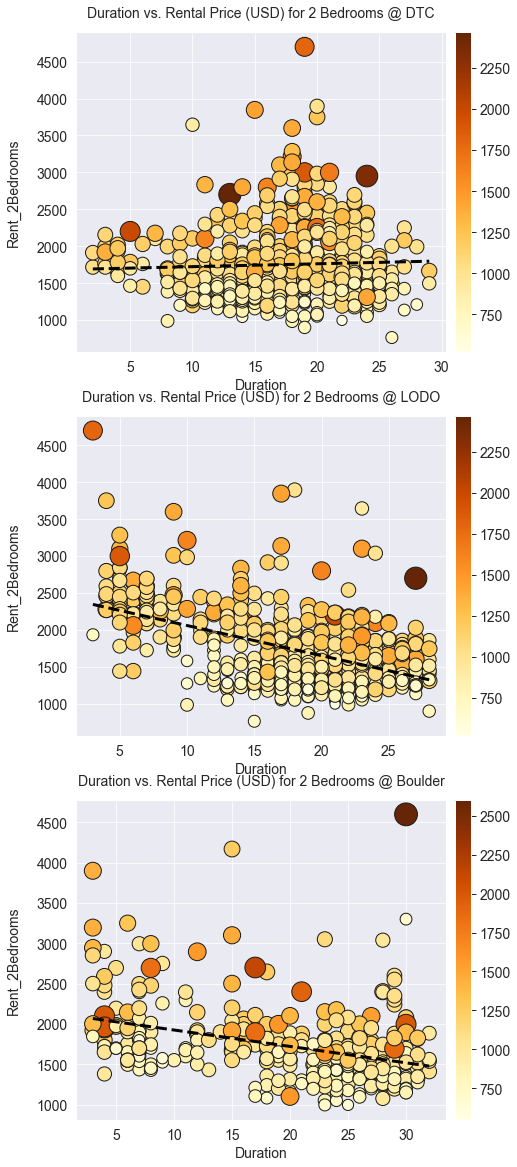

In [123]:
df_dtc = df_merge.query('Area == "DTC"')
df_lodo = df_merge.query('Area == "LODO"')
df_boulder = df_merge.query('Area == "Boulder"')

df_list = [df_dtc, df_lodo, df_boulder]

fig, subaxes = plt.subplots(3, 1, figsize=(8,20))

# area = df_boulder.Area.unique()[0]
# bedroom_type = 2
# correlation_regplot_rental_price(df_dtc, ax, area, bedroom_type, 'Duration')
# plt.savefig(f'scatter_plot_duration_vs_rental_price_{bedroom_type}bedroom(s)_{area}.png')

for df, ax in zip(df_list, subaxes):
    bedroom_type = 2 # 1 or 2 bedrooms
    area = df.Area.unique()[0]
    correlation_regplot_rental_price(df, ax, area, bedroom_type, 'Duration')
#     plt.savefig(f'scatter_plot_duration_vs_rental_price_{bedroom_type}bedroom(s)_{area}.png')

## Q3.  Does newly built property rent for a higher price?

<div class="alert alert-block alert-info">
    <font size="4"><p>Draw a scatter plot with <b><tt>Rental Price</tt></b> versus <b><tt>Year built</tt></b> colored by <b><tt>Binned Total Units</tt></b> for each area. </p></font>
    <font size="3"><p style="text-indent: 20px">- Use <b><tt><i>Pandas Histogram</i></tt></b> to find reasonable binning criteria.</p>
    <p style="text-indent: 20px">- Use <b><tt><i>pd.cut</i></tt></b> to divide <b><tt>Total Units</tt></b> into 4 bins.</p></font>
</div>

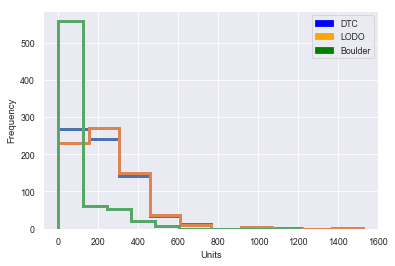

In [23]:
# Check histogram of total units for the areas in order to binning by units of apartment
dtc = df_dtc['Total_Units'].plot(kind='hist', lw=3, histtype='step')
lodo = df_lodo['Total_Units'].plot(kind='hist', lw=3, histtype='step')
boulder = df_boulder['Total_Units'].plot(kind='hist', lw=3, histtype='step')

dtc_patch = mpatches.Patch(color='blue', label='DTC')
lodo_patch = mpatches.Patch(color='orange', label='LODO')
boulder_patch = mpatches.Patch(color='green', label='Boulder')

plt.xlabel('Units')
plt.legend(handles=[dtc_patch, lodo_patch, boulder_patch])

In [134]:
# Binning by total unit counts
df_dtc['Total_Units_bins'] = pd.cut(df_dtc['Total_Units'], bins=[0,199,399,799,1600], labels=["Units < 200", "200 ≤ Units < 400", "400 ≤ Units < 800", "Units ≥ 800"], include_lowest=True)
df_lodo['Total_Units_bins'] = pd.cut(df_lodo['Total_Units'], bins=[0,199,399,799,1600], labels=["Units < 200", "200 ≤ Units < 400", "400 ≤ Units < 800", "Units ≥ 800"], include_lowest=True)
df_boulder['Total_Units_bins'] = pd.cut(df_boulder['Total_Units'], bins=[0,199,399,799,1600], labels=["Units < 200", "200 ≤ Units < 400", "400 ≤ Units < 800", "Units ≥ 800"], include_lowest=True)


In [187]:
# draw a chart to show a correlation between 'Year_built' and rental price colored by binned total units.

def Plot_Year_built(df, ax, area, color_by, color_scheme, Bedroom_type=1):
    
    x_axis = df['Year_built']
    
    if Bedroom_type == 1:
        y_axis = df['Rent_1Bedroom']
        label = "1 Bedroom"
    elif Bedroom_type == 2:
        y_axis = df['Rent_2Bedrooms']
        label = "2 Bedroom"
  
    colors = df[color_by].map(lambda x: color_scheme.get(x, 'grey'))

    #ax.grid()
    ax.scatter(x_axis, y_axis, c=colors, s=120, edgecolors='k', lw=0.5, alpha=0.8,
               label='_nolegend_')

#     # Legend for color by total units
    for unit_bin, color in color_scheme.items():
        ax.scatter([], [], c=color, alpha=0.8, lw=1, edgecolors='black', label=unit_bin)
        ax.legend(fontsize=14, scatterpoints=1, markerscale=1.5, labelspacing=0.5)

    ax.set(xlim=[1900, 2030], ylim=[500, 2500])
    ax.set_xlabel('Year_built', fontsize=14)
    ax.set_ylabel('Rental price (USD)', fontsize=14, labelpad=15)
    ax.set_title(f'Rental price vs. Year_built for {label} @ {area}', fontsize=14, pad=15)
    ax.tick_params(labelsize=14)

    #Add a Seaborn Regression plot for drawing a regression line per each area
    sns.set()
    sns.regplot(x_axis, y_axis, data=df,
                order=2, ci=None, truncate=True,
                scatter=False, label=label,
                line_kws={'color':'red', 'lw': 3, 'ls' : '--'}, ax=ax)
    

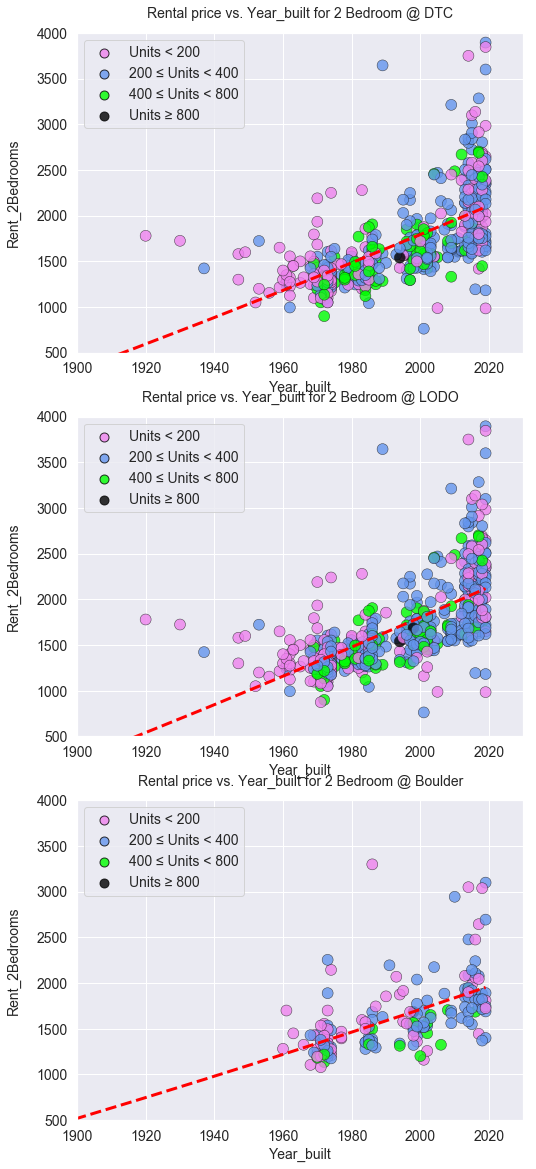

In [183]:
color_dict = {'Units < 200' : 'violet',
              '200 ≤ Units < 400' : 'cornflowerblue',
              '400 ≤ Units < 800' : 'lime',
              'Units ≥ 800' : 'black'}

df_list = [df_dtc, df_lodo, df_boulder]

fig, subaxes = plt.subplots(3, 1, figsize=(8,20))

# area = df_dtc.Area.unique()[0]
# bedroom_type = 2
# Plot_Year_built(df_dtc, ax, area, color_by='Total_Units_bins', color_scheme=color_dict, Bedroom_type=bedroom_type)
# plt.savefig(f'scatter_plot_yearbuilt_vs_rental_price_by_units_{bedroom_type}bedroom(s)_{area}.png')

for df, ax in zip(df_list, subaxes):
    area = df.Area.unique()[0]
    bedroom_type = 2
    Plot_Year_built(df, ax, area, color_by='Total_Units_bins', color_scheme=color_dict, Bedroom_type=bedroom_type)


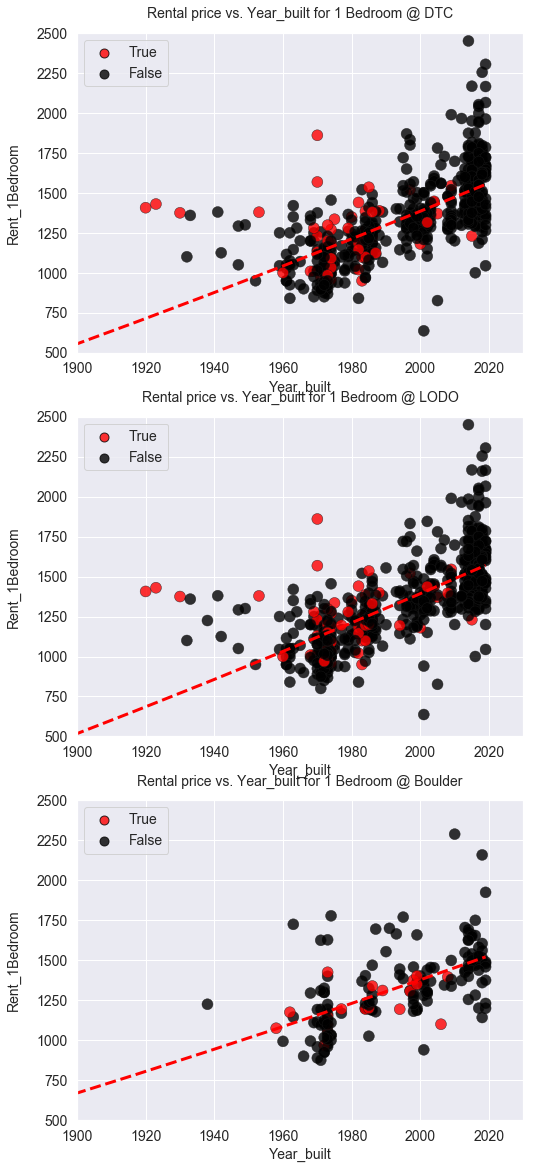

In [190]:
color_dict = {
              True : 'red',
              False : 'black'
             }

df_list = [df_dtc, df_lodo, df_boulder]

fig, subaxes = plt.subplots(3, 1, figsize=(8,20))

# area = df_boulder.Area.unique()[0]
# bedroom_type = 1
# Plot_Year_built(df_dtc, ax, area, color_by='Renovated', color_scheme=color_dict, Bedroom_type=bedroom_type)
# plt.savefig(f'scatter_plot_yearbuilt_vs_rental_price_by_renovated_{bedroom_type}bedroom(s)_{area}.png')

for df, ax in zip(df_list, subaxes):
    area = df.Area.unique()[0]
    bedroom_type = 1
    Plot_Year_built(df, ax, area, color_by='Renovated', color_scheme=color_dict, Bedroom_type=bedroom_type)


## Q4.  What happens to rental unit SQFT as distance increase from each location?

<div class="alert alert-block alert-info">
    <font size="4">Draw a scatter plot with <b><tt>Rental Price</tt></b> versus <b><tt>Squre-footage</tt></b></font>
</div>

In [191]:
# Draw correlation plot between square-footage and distance (or duration)
def correlation_plot_sqft(df, ax, area, Bedroom_type=1, field='Distance'):    
    x_axis = df[field]
    if Bedroom_type == 1:
        y_axis = df['Size_1Bedroom']
        label = "1 Bedroom"
    elif Bedroom_type == 2:
        y_axis = df['Size_2Bedrooms']
        label = "2 Bedrooms"
    else:
        print("You need to put 1 or 2 for the parameter 'Bedroom_type'.")
        
    scatter = ax.scatter(x_axis, y_axis, s=130, c='gold', edgecolor='k', lw=1, label=label, alpha=0.8)
    ax.set_title(f'{field} vs. Square footage for {label} @ {area}', fontsize=14, pad=15)
    ax.set_xlabel(f'{field}', fontsize=14)
    ax.set_ylabel("Square footage", fontsize=14, labelpad=15)
    ax.tick_params(labelsize=14)
#     ax.legend(fontsize=13)
    
    sns.regplot(x_axis, y_axis, data=df,
                order=1, ci=None, truncate=True,
                scatter=False, label=label,
                line_kws={'color':'red', 'lw': 3, 'ls' : '--'}, ax=ax)

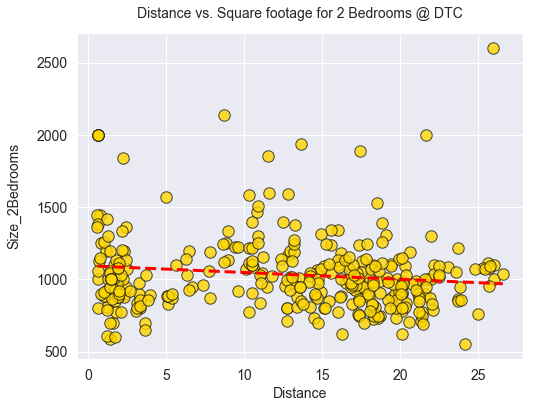

In [205]:
df_list = [df_dtc, df_lodo, df_boulder]

fig, ax = plt.subplots(1, 1, figsize=(8,6))

area = df_dtc.Area.unique()[0]
bedroom_type = 2
correlation_plot_sqft(df, ax, area, Bedroom_type=bedroom_type, field='Distance')
plt.savefig(f'scatter_plot_distance_vs_sqft_{bedroom_type}bedroom(s)_{area}.png')

# for df, ax in zip(df_list, subaxes):
#     area = df.Area.unique()[0]
#     bedroom_type = 1
#     correlation_plot_sqft(df, ax, area, Bedroom_type=bedroom_type, field='Distance')

## Q5.  Does the apartment data correlate with the zip code based Median Contract Rental price from the 2017 Census data?

<div class="alert alert-block alert-info">
    <font size="4"><p>Find a correlation between actual rental price and contract rent from <b><tt><i>Census</i></tt></b> data based on zip codes.</p>
    <font size="3"><p style="text-indent: 20px">- Calculate actual median rental price by <b><tt><i>groupby</i></tt></b> method.</p></font>
    <font size="3"><p style="text-indent: 20px">- Draw a scatter plot with <b><tt><i>actual median rental price</i></tt></b> and <b><tt><i>median contract rent</i></tt></b> from <b><tt><i>Census</i></tt></b>.</p></font>    
</div>

In [212]:
# Calculate current median rental price by zipcode
# and compare with the median contract rental price from the Census 2017 data 
df_corr_median_contract_rent = df_merge.groupby(['apt_zipcode']).agg({'Rent_1Bedroom' : [np.median],
                                                                      'Rent_2Bedrooms' : [np.median],
                                                                      'median_contract_rent' : 'mean'}
                                                               ).reset_index()

# Renaming the columns
df_corr_median_contract_rent.columns = ['_'.join(col) for col in df_corr_median_contract_rent.columns.values]


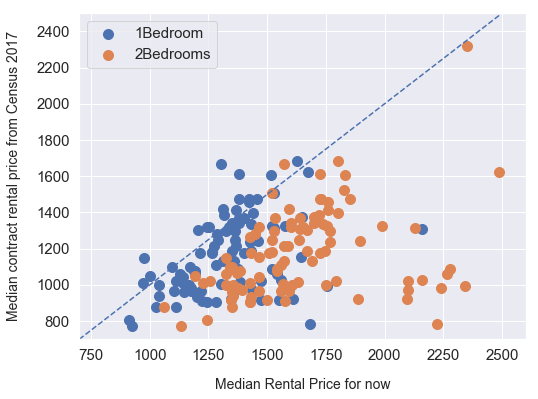

In [213]:

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.scatter(data=df_corr_median_contract_rent, x='Rent_1Bedroom_median', y='median_contract_rent_mean', s=100, label="1Bedroom")
ax.scatter(data=df_corr_median_contract_rent, x='Rent_2Bedrooms_median', y='median_contract_rent_mean', s=100, label="2Bedrooms")
ax.plot(np.arange(700,2500,10), np.arange(700,2500,10), '--')

ax.set_xlabel("Median Rental Price for now", fontsize=14, labelpad=15)
ax.set_ylabel("Median contract rental price from Census 2017", fontsize=14, labelpad=15)
ax.set(xlim=[700, 2600], ylim=[700, 2500])
ax.tick_params(labelsize=15)

ax.legend(fontsize=15, markerscale=1)

plt.savefig('scatter_plot_rental_price_vs_census')

In [32]:
# Check the most price-increased zip codes
df_corr_median_contract_rent['diff_1Bedroom'] = df_corr_median_contract_rent['Rent_1Bedroom_median'] - df_corr_median_contract_rent['median_contract_rent_mean']
df_corr_median_contract_rent['diff_2Bedrooms'] = df_corr_median_contract_rent['Rent_2Bedrooms_median'] - df_corr_median_contract_rent['median_contract_rent_mean']

columns_interested = ['apt_zipcode_', 'Rent_2Bedrooms_median', 'median_contract_rent_mean', 'diff_2Bedrooms']

df_corr_median_contract_rent[columns_interested].sort_values(by='diff_2Bedrooms', ascending=False).head(5)

,apt_zipcode_,Rent_2Bedrooms_median,median_contract_rent_mean,diff_2Bedrooms
45,80204,2222.5,784.0,1438.5
51,80211,2343.5,995.0,1348.5
55,80216,2240.0,983.0,1257.0
46,80205,2265.0,1058.0,1207.0
50,80210,2280.0,1087.0,1193.0


<div class="alert alert-block alert-info">
    <font size="4"><p>Draw a choroleth plot overlaid by bubble plot.</p>
    <font size="3"><p style="text-indent: 20px">- Use <b><tt><i>Folium</i></tt></b> package for drawing a choropleth map and bubble plot at the same time, and <b><tt><i>Branca</i></tt></b> color mapping package for coloring the bubbles.</p></font>    
    <font size="3"><p style="text-indent: 20px">- a choroleth plot colored by <b><tt><i>Median contract rent</i></tt></b> by zipcode.</p></font>
     <font size="2"><p style="text-indent: 40px">- For a zipcode-base choroleth plot, get zipcode-based <b><tt><i>GeoJSON file</i></tt></b> from public site and remove unnecessary zipcode data.</p></font>
    <font size="3"><p style="text-indent: 20px">- a bubble plot sized and colored by <b><tt><i>Rental Price</i></tt></b></p></font>
</div>

In [33]:
# Colorado zipcode information from "https://data-cdphe.opendata.arcgis.com/"
base_url = 'https://opendata.arcgis.com/datasets/6b6091f299204e4c9c406a624baf43e6_10.geojson'
data = requests.get(base_url).json()

# Collecting necessary zipcode information from the original geojson
colorado_zipcode = []
for _ in range(len(data.get('features'))):
    if data.get('features')[_].get('properties').get('ZCTA5CE10') in df_merge['apt_zipcode'].unique():
        colorado_zipcode.append(data.get('features')[_])
        
# Creating a new JSON object
geojson_trimmed = dict.fromkeys(['type','features'])
geojson_trimmed['type'] = 'FeatureCollection'
geojson_trimmed['features'] = colorado_zipcode

# Save JSON object as newfile
with open("Colorado_trimmed.json", "w") as f:
    f.write(
            json.dumps(geojson_trimmed, sort_keys=True, indent=4, separators=(',', ': '))
    )
    
colorado_geojson = r'Colorado_trimmed.json'

In [34]:
# Get geocoordinates for each center point of dtc, lodo, and boulder
dtc_addr = '4900 S Syracuse St, Denver, CO 80237'
lodo_addr = '1634 18th St, Denver, CO 80202'
boulder_addr = '1710 29th St, Boulder, CO 80301'

dtc_geocoords = extract_geocoordinates(dtc_addr)
lodo_geocoords = extract_geocoordinates(lodo_addr)
boulder_geocoords = extract_geocoordinates(boulder_addr)

In [225]:
# Draw a choropleth map overlaid by bubble plot
def plot_choropleth_and_bubble_by_rental_price(df, geojson, map_center, choropleth_color_by , Bedroom_type=1):

    m = folium.Map(location=map_center,
                   tiles='Cartodb Positron', #OpenStreetMap',
                   zoom_start=9,
                   prefer_canvas=True,
                   control_scale=True
    )
#     TileLayer(tiles='Cartodb Positron').add_to(m)

    # Draw a choropleth map for colordo with geojson file containing necessary zipcode information only
    folium.Choropleth(
        geo_data=geojson,
        data=df,
        columns=['apt_zipcode', choropleth_color_by],
        key_on='feature.properties.ZCTA5CE10',
        fill_color='BuPu',
        fill_opacity=0.7,
        line_opacity=0.5,
        legend_name=f'{choropleth_color_by} by zipcode',
        reset=True
    ).add_to(m)


    # Draw a circle with radius 20mi from the center of each area
    # Gather the circles into each feature group for interactive visualization
    DTC_20mi = FeatureGroup(name='20mi Circle for DTC')
    Lodo_20mi = FeatureGroup(name='20mi Circle for Lodo')
    Boulder_20mi = FeatureGroup(name='20mi Circle for Boulder')

    folium.Circle(
          location=dtc_geocoords,
          popup="a circle area with 20 mi radius from the center point of DTC",
          radius= 32187,  # 20 mi
          color='grey',
          fill=False
       ).add_to(DTC_20mi)

    folium.Circle(
          location=lodo_geocoords,
          popup="a circle area with 20 mi radius from the center point of LODO",
          radius= 32187,  # 20 mi
          color='grey',
          fill=False
       ).add_to(Lodo_20mi)

    folium.Circle(
          location=boulder_geocoords,
          popup="a circle area with 20 mi radius from the center point of Boulder",
          radius= 32187,  # 20 mi
          color='grey',
          fill=False
       ).add_to(Boulder_20mi)

    DTC_20mi.add_to(m)
    Lodo_20mi.add_to(m)
    Boulder_20mi.add_to(m)

    # Draw a bubble plot whose size is defined by rental price in each area
    if Bedroom_type == 1:
        rental_price_column = 'Rent_1Bedroom'
        divider_for_bubble_radius = 1000
    elif Bedroom_type == 2:
        rental_price_column = 'Rent_2Bedrooms'
        divider_for_bubble_radius = 1300
            
    df_temp = df[df[rental_price_column].isnull() == False]

    dtc_df = df_temp.query('Area=="DTC"')
    lodo_df = df_temp.query('Area=="LODO"')
    boulder_df = df_temp.query('Area=="Boulder"')

    # Branca colormap for bubbles by rental price
    colormap = linear.YlOrBr_09.scale(
               df_temp[rental_price_column].min(),
               df_temp[rental_price_column].max()
    )

    colormap.caption = f'Rental price for {Bedroom_type} Bedroom(s)'
    m.add_child(colormap)

    # Feature grouping to enhance the interactiveness
    DTC_apartments = FeatureGroup(name='DTC apartments')
    Lodo_apartments = FeatureGroup(name='Lodo apartments')
    Boulder_apartments = FeatureGroup(name='Boulder apartments')

    df_list = [dtc_df, lodo_df, boulder_df]
    fgroup_list = [DTC_apartments, Lodo_apartments, Boulder_apartments]

    # Using circle marker to represent bubbles sized and colored by rental price
    for df_tmp, fgroup in zip(df_list, fgroup_list):
        for i in range(len(df_tmp)):
            folium.CircleMarker(
              location=df_tmp.iloc[i]['apt_geocoords'],      
              radius=np.exp(df_tmp.iloc[i][rental_price_column] / divider_for_bubble_radius),
              popup=f'Rental Price:\n 1Bedroom: {df_tmp.iloc[i]["Rent_1Bedroom"]}\n 2Bedrooms: {df_tmp.iloc[i]["Rent_2Bedrooms"]}',        
              fill= True,
              fill_color=colormap(df_tmp.iloc[i][rental_price_column]),
              fill_opacity=0.8,
              stroke= True,
              color='black',
              opacity=0.3,
              weight= 1.5,  # stroke width in pixel
              highlight= True
            ).add_to(fgroup)
        fgroup.add_to(m)

    minimap = plugins.MiniMap(toggle_display=True, tile_layer='Stamen Toner', zoom_level_offset=-5)
    fullscreen = plugins.Fullscreen(position='topright')
    m.add_child(minimap)
    m.add_child(fullscreen)
    
    LayerControl().add_to(m)
    
    return m

In [226]:
# To solve the problem on not showing the result map in Jupyter notebook
def embed_map(m, save_file_name):
    from IPython.display import IFrame

    m.save(os.path.join('.', save_file_name))
    
    return IFrame(save_file_name, width='90%', height='500px')

In [228]:
bedroom_type = 1

m = plot_choropleth_and_bubble_by_rental_price(df_merge, colorado_geojson, lodo_geocoords,
                                               choropleth_color_by='median_contract_rent',
                                               Bedroom_type=bedroom_type)

embed_map(m, f'choropleth_and_bubble_global_{bedroom_type}bedroom(s).html')